# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

**Data Description**
<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


In [2]:
#use read_csv to read our csv data file.
#use head() to show few rows in our data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
#some information about data
#shape(5,294478)
#there is no missing
#timestamp is not time data type.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
#check duplicated values
#there is no duplicated values
df.duplicated().sum()

0

**b.** Use the cell below to find the number of rows in the dataset.

In [5]:
#number of rows.
print('number of rows: {}'.format(df.shape[0]))

number of rows: 294478


**c.** The number of unique users in the dataset.

In [6]:
#there are 3894 experiments done by users who have done more than one ا (294478-290584)
print('number of unique users: {}'.format(df.user_id.nunique()))

number of unique users: 290584


**d.** The proportion of users converted.

In [7]:
users_converted_proportion = df.converted.mean()
print('the proportion of users converted: {}'.format(users_converted_proportion))

the proportion of users converted: 0.11965919355605512


**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [8]:
#################
treatment_wrong = 0

for i in range(df.shape[0]):
    if df.group[i]=='treatment' and df.landing_page[i]!='new_page':
        treatment_wrong += 1
        
print('number of time when treatment is new_page: {}'.format(treatment_wrong))

number of time when treatment is new_page: 1965


**f.** Do any of the rows have missing values?

In [9]:
#there is no any missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [11]:
#Remove the inaccurate rows, and store the result in a new dataframe df2
condition1 = ((df['group']=='control') == (df['landing_page']=='old_page')) == True
condition2 = ((df['group']=='treatment')==(df['landing_page']=='new_page')) == True
df2 = df[condition1 & condition2]
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


In [12]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [13]:
#there are 290584 unique users in df2
df.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [14]:
#the repeated user have id: 773192
repeated_user = df2[df2.user_id.duplicated()==True].user_id.unique()
print('the repeated user have id: {}'.format(repeated_user))

the repeated user have id: [773192]


**c.** Display the rows for the duplicate **user_id**? 

In [15]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [16]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop(1899,axis=0)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0



**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>


In [17]:
p_pop = df2.converted.mean()
p_pop

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
p_control_converted = df2[df2.group == 'control'].converted.mean()
p_control_converted

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
p_treatment_converted = df2[df2.group == 'treatment'].converted.mean()
p_treatment_converted

0.11880806551510564

In [20]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment_converted-p_control_converted
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [21]:
p_new_page = (df2['landing_page'] == 'new_page').mean()
p_new_page

0.50006194422266881

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**Answer:**

Initially, there is no evidence that the conversion rate in the treatment group is different than the conversion rate in the control group, since p_control=0.1203 and p_treatment=0.1188, and the difference between the conversion rates in both groups is 0.0015, meaning that they are almost the same, taking into account that the rate of new page appearances is the same  The appearance of the old page, however, should not make a decision based on this conclusion and should look for other factors that may affect the result.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  



>**Answer:**

Null:        **$H_{0}$**:  **$p_{new}$** <= **$p_{old}$**

Alternative: **$H_{1}$**: **$p_{new}$**  > **$p{old}$**

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [22]:
#under the null, we assume that coversion rate for population equal for new and old page.
#conversion rate for population: df2.converted.mean()
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [23]:
p_old = p_new
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [24]:
n_new = df2[df2.landing_page=='new_page'].landing_page.count()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [25]:
#n_old approximately equal n_new 
n_old = df2[df2.landing_page=='old_page'].landing_page.count()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [26]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1],n_new,[p_new,1-p_new])
new_page_converted

array([0, 0, 1, ..., 0, 1, 1])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [27]:
# Simulate a Sample for the control Group6
old_page_converted = np.random.choice([0,1],n_old,[p_old, 1-p_old])
old_page_converted

array([0, 1, 0, ..., 1, 0, 1])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [28]:
obs_diff2 = new_page_converted.mean()-old_page_converted.mean()
obs_diff2

-0.0016655738280332844


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [29]:
# Sampling distribution 
'''
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0,1],n_new,p=[1-p_new,p_new],replace=True)
    old_page_converted = np.random.choice([0,1],n_old,p=[1-p_old,p_old],replace=True)
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())
'''
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new 
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation


In [30]:
#convert p_diff list to array
#show sample
p_diffs = np.array(p_diffs)
p_diffs

array([-0.00179165,  0.00042479,  0.00010135, ..., -0.00090375,
       -0.00050461,  0.00070692])

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

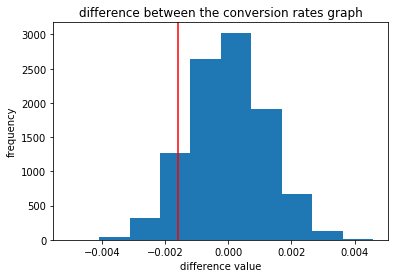

In [31]:
plt.hist(p_diffs);
plt.title('difference between the conversion rates graph')
plt.xlabel('difference value')
plt.ylabel('frequency')
plt.axvline(obs_diff,color='r');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [32]:
#bs_diff = p_treatment_converted - p_control_converted
(p_diffs > obs_diff).mean()

0.9083

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

**the value in the last cell called p_value, and compared to 
alpha(type 1 error rate)=0.05 p_value is larg, that is mean that
90% of our data which is represent population is higer than 
observation difference.**

**in this case we cannot say that the new page is doing better than old page,
that is (we cannot reject the null hypothesis)**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [33]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page=='old_page' and converted==1").count()[0]

# number of conversions with the new_page
convert_new = df2.query("landing_page=='new_page' and converted==1").count()[0]

# number of individuals who were shown the old_page
n_old = df2[df2.landing_page=='old_page'].landing_page.count()

# number of individuals who received new_page
n_new = df2[df2.landing_page=='new_page'].landing_page.count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [34]:
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [35]:
#import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new],alternative='smaller')
print(z_score, p_value)

1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

**since alternative hypothesis H1: p_{new}>p_{old}, its right_tailed test
and we compute z_score=1.31 is less than z_{alpha}=1.645 that is mean that z_score
in acceptance area and in this case we cannot reject null hypothesis
(we cannot say that the new page is doing better than the old page.**
 
**this conclusion agree with the finding in part j**
 
**again p_value is larg compared with alpha,this is proof of correctness of null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression: given that the results we are dealing with are binary.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [36]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2.group).treatment
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [37]:
linear_model = sm.Logit(df2.converted, df2[['intercept','ab_page']])
result = linear_model.fit()
#result.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-03-22 17:37 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


**we have found that p_value associated with ab_page = 0.1899, that is a big number compared to alpha(type 1 error rate)=0.05, this is indicates that ab_page is not sufficiently related to the prediction of the response variable, That is, we cannot say that the new page is better than old page, or (we cannot reject the null hypothesis)**

**Although the result are the same using linear regression or hypothesis testing in part II, but p_value should be differ from p_value in part II, because the hypotheses we testing in two way are different**

**in part II we did one_sided(or one_tailed) test because the alternative assume that the new page has the higher conversion rate than old page. but in regression case the test was two_sided test because alternative hypothesis was !=, and this mean that even if the new page is worse than the old page the alternative still true.**

**null and alternative in part II in the form:**

Null:        **$H_{0}$**:  **$p_{new}$** <= **$p_{old}$**

Alternative: **$H_{1}$**: **$p_{new}$**  > **$p_{old}$**

**in regression shold be in the form:**


Null:        **$H_{0}$**:  **$p_{new}$** = **$p_{old}$**

Alternative: **$H_{1}$**: **$p_{new}$**  != **$p_{old}$**


**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**There may certainly be some other factors that are likely to affect the response variable (conversion rate) and it is necessary to consider these factors for the credibility of the decision we will make based on the model
There are some disadvantages that can appear when dealing with many factors, there may be a correlation Between these factors and some of them in the model and thus show a false inverse response to the response variable**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [39]:
# Read the countries.csv
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
countries_df.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [41]:
countries_df.shape[0] == df2.shape[0]

True

In [42]:
#countries_df.user_id.unique() == df2.user_id.unique()

In [43]:
# Join with the df2 dataframe
df_merged = df2.merge(countries_df,how='inner',on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [44]:
# Create the necessary dummy variables
df_merged[['CA','UK','US']] = pd.get_dummies(df_merged.country)
df_merged['ab_page_us'] = df_merged.ab_page * df_merged.US
df_merged['ab_page_uk'] = df_merged.ab_page * df_merged.UK
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ab_page_us,ab_page_uk
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [45]:
# Fit your model, and summarize the results
# choode CA is a baseline
lm2 = sm.Logit(df_merged.converted, df_merged[['intercept','ab_page','US','UK','ab_page_us','ab_page_uk']])
lm2.fit().summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-03-22 17:37 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
ab_page_us     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
ab_page_uk     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

**we found that all p_values for variables is large compared to type one error rate,this is indicates that country is not sufficiently related to the prediction of the response variable conversion rate.**

**now we can say that country has no effect on whether the individual will pay or not, meaning that it has no effect on the vonversion rate.**

**in the end, this confirms that the claim that the new page is not better than old page is true, in this case we cannot reject the null hypothesis.**

In [46]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0